In [ ]:
# =========================
# 0) Imports
# =========================
import pandas as pd
import numpy as np
import random
from datetime import datetime, timedelta

random.seed(42)
np.random.seed(42)

# =========================
# 1) Config (your exact requirements)
# =========================
college_counts = {
    "Malla Reddy Engineering College": 80,
    "CMR College of Engineering": 80,
    "Gunupur College of Engineering": 100,
    "Sreedevi Engineering College": 40
}
departments = ["CS", "IT"]
batch_year = 2024

courses = [
    ("C01", "Python for Data", 20),
    ("C02", "SQL Fundamentals", 15),
    ("C03", "Machine Learning", 25),
    ("C04", "Java Programming", 18),
    ("C05", "Cloud Computing", 22),
]

def random_date_last_year():
    end = datetime.today()
    start = end - timedelta(days=365)
    return (start + timedelta(days=random.randint(0, 365))).date()

# =========================
# 2) Create Students table (exact counts)
# =========================
students = []
sid = 1
for college, count in college_counts.items():
    for _ in range(count):
        students.append([
            f"S{sid:03d}",
            college,
            random.choice(departments),
            batch_year
        ])
        sid += 1

students_df = pd.DataFrame(students, columns=["student_id", "college", "department", "batch_year"])

# =========================
# 3) Create Courses table
# =========================
courses_df = pd.DataFrame(courses, columns=["course_id", "course_name", "total_modules"])
courses_df["max_score"] = 100

# =========================
# 4) Create Enrollments base table (1–3 courses per student)
# =========================
enrollments = []

for _, s in students_df.iterrows():
    num_courses = random.randint(1, 3)
    selected = random.sample(courses, num_courses)

    for course_id, course_name, total_modules in selected:
        modules_completed = random.randint(0, total_modules)

        if modules_completed == total_modules:
            status = "Completed"
        elif modules_completed > int(total_modules * 0.4):
            status = "In Progress"
        else:
            status = "Dropped"

        # realistic-ish score/attendance by status
        if status == "Completed":
            score = random.randint(60, 100)
            attendance = random.randint(70, 100)
        elif status == "In Progress":
            score = random.randint(40, 85)
            attendance = random.randint(50, 95)
        else:
            score = random.randint(0, 65)
            attendance = random.randint(30, 70)

        enrollments.append([
            s["student_id"],
            course_id,
            random_date_last_year(),
            modules_completed,
            total_modules,
            score,
            attendance,
            status
        ])

enrollments_df = pd.DataFrame(enrollments, columns=[
    "student_id", "course_id", "enrollment_date",
    "modules_completed", "total_modules",
    "score", "attendance_pct", "status"
])

# =========================
# 5) Feature engineering (matches Excel workbook)
# IMPORTANT: month is TEXT (YYYY-MM), not Period
# =========================
enrollments_df["enrollment_date"] = pd.to_datetime(enrollments_df["enrollment_date"])
enrollments_df["completion_pct"] = enrollments_df["modules_completed"] / enrollments_df["total_modules"]
enrollments_df["is_completed"] = (enrollments_df["status"] == "Completed").astype(int)
enrollments_df["is_pass"] = (enrollments_df["score"] >= 60).astype(int)
enrollments_df["month"] = enrollments_df["enrollment_date"].dt.strftime("%Y-%m")  # KEY for SQL/Sheets

# Join to create the final fact table EXACTLY like Excel "Enrollments" sheet
full_data = (
    enrollments_df
    .merge(students_df, on="student_id")
    .merge(courses_df[["course_id", "course_name"]], on="course_id")
)

# Reorder columns to match the Excel workbook
full_data = full_data[[
    "student_id", "college", "department", "batch_year",
    "course_id", "course_name", "enrollment_date",
    "modules_completed", "total_modules", "completion_pct",
    "score", "attendance_pct", "status", "is_completed", "is_pass", "month"
]]

full_data.head()


,student_id,college,department,batch_year,course_id,course_name,enrollment_date,modules_completed,total_modules,completion_pct,score,attendance_pct,status,is_completed,is_pass,month
0,S001,Malla Reddy Engineering College,CS,2024,C02,SQL Fundamentals,2025-10-24,1,15,0.066667,47,67,Dropped,0,0,2025-10
1,S002,Malla Reddy Engineering College,CS,2024,C04,Java Programming,2025-07-20,4,18,0.222222,5,49,Dropped,0,0,2025-07
2,S003,Malla Reddy Engineering College,IT,2024,C03,Machine Learning,2025-07-15,6,25,0.240000,31,36,Dropped,0,0,2025-07
3,S004,Malla Reddy Engineering College,CS,2024,C04,Java Programming,2025-01-27,5,18,0.277778,22,56,Dropped,0,0,2025-01
4,S004,Malla Reddy Engineering College,CS,2024,C02,SQL Fundamentals,2025-12-23,5,15,0.333333,42,56,Dropped,0,0,2025-12


In [ ]:
# College_Summary
college_summary = full_data.groupby("college").agg(
    total_students=("student_id", "nunique"),
    total_enrollments=("student_id", "count"),
    completion_rate_pct=("is_completed", lambda x: round(x.mean()*100, 2)),
    pass_rate_pct=("is_pass", lambda x: round(x.mean()*100, 2)),
    avg_score=("score", lambda x: round(x.mean(), 2)),
    avg_attendance=("attendance_pct", lambda x: round(x.mean(), 2))
).reset_index()

# Course_Summary
course_summary = full_data.groupby(["course_id", "course_name"]).agg(
    total_enrollments=("student_id", "count"),
    completion_rate_pct=("is_completed", lambda x: round(x.mean()*100, 2)),
    pass_rate_pct=("is_pass", lambda x: round(x.mean()*100, 2)),
    avg_score=("score", lambda x: round(x.mean(), 2))
).reset_index()

# Monthly_Trend
monthly_trend = full_data.groupby("month").agg(
    enrollments=("student_id", "count"),
    completion_rate_pct=("is_completed", lambda x: round(x.mean()*100, 2)),
    avg_score=("score", lambda x: round(x.mean(), 2))
).reset_index().sort_values("month")

college_summary, course_summary, monthly_trend.head()


(                           college  total_students  total_enrollments  \
 0       CMR College of Engineering              80                157   
 1   Gunupur College of Engineering             100                190   
 2  Malla Reddy Engineering College              80                162   
 3     Sreedevi Engineering College              40                 88   
 
    completion_rate_pct  pass_rate_pct  avg_score  avg_attendance  
 0                 7.01          35.67      51.41           66.37  
 1                 4.21          38.95      51.82           64.49  
 2                 3.70          39.51      51.93           66.41  
 3                 2.27          30.68      50.95           63.72  ,
   course_id       course_name  total_enrollments  completion_rate_pct  \
 0       C01   Python for Data                106                 2.83   
 1       C02  SQL Fundamentals                103                 6.80   
 2       C03  Machine Learning                133                

In [ ]:
students_df.to_csv("students.csv", index=False)
courses_df.to_csv("courses.csv", index=False)
full_data.to_csv("clean_enrollments.csv", index=False)
college_summary.to_csv("college_summary.csv", index=False)
course_summary.to_csv("course_summary.csv", index=False)
monthly_trend.to_csv("monthly_trend.csv", index=False)

print("✅ CSVs exported: students.csv, courses.csv, clean_enrollments.csv, college_summary.csv, course_summary.csv, monthly_trend.csv")


✅ CSVs exported: students.csv, courses.csv, clean_enrollments.csv, college_summary.csv, course_summary.csv, monthly_trend.csv


In [ ]:
# If openpyxl is missing in Colab, run:
# !pip install openpyxl

with pd.ExcelWriter("Freelance_Campus_Training_Analytics.xlsx", engine="openpyxl") as writer:
    students_df.to_excel(writer, sheet_name="Students", index=False)
    courses_df.to_excel(writer, sheet_name="Courses", index=False)
    full_data.to_excel(writer, sheet_name="Enrollments", index=False)
    college_summary.to_excel(writer, sheet_name="College_Summary", index=False)
    course_summary.to_excel(writer, sheet_name="Course_Summary", index=False)
    monthly_trend.to_excel(writer, sheet_name="Monthly_Trend", index=False)

print("✅ Excel created: Freelance_Campus_Training_Analytics.xlsx")


✅ Excel created: Freelance_Campus_Training_Analytics.xlsx


In [6]:
import pandas as pd

# If your main fact table is named full_data (recommended)
df = full_data.copy()

total_students = df["student_id"].nunique()
completion_rate = df["is_completed"].mean() * 100
pass_rate = df["is_pass"].mean() * 100
avg_score = df["score"].mean()

kpi_df = pd.DataFrame({
    "Total Students": [total_students],
    "Completion Rate": [f"{completion_rate:.2f}%"],
    "Pass Rate": [f"{pass_rate:.2f}%"],
    "Avg Score": [f"{avg_score:.2f}"]
})

kpi_df



,Total Students,Completion Rate,Pass Rate,Avg Score
0,300,4.52%,37.02%,51.61


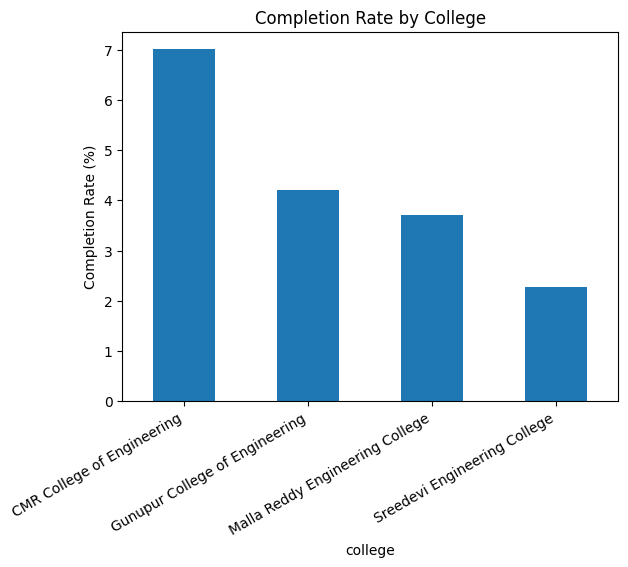

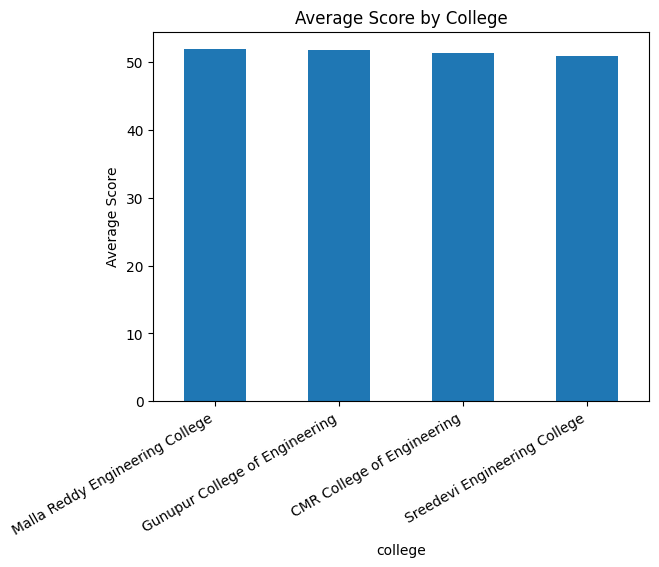

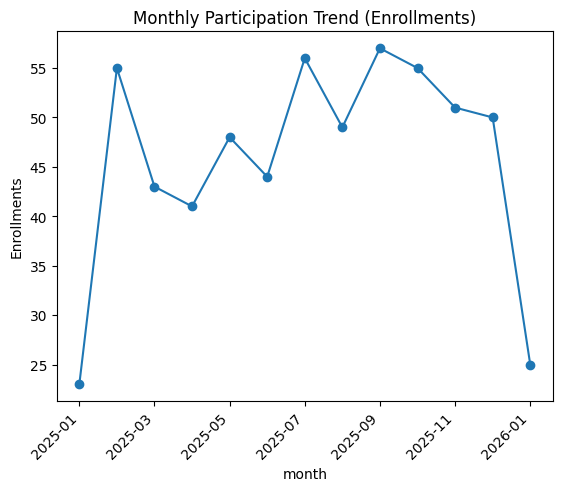

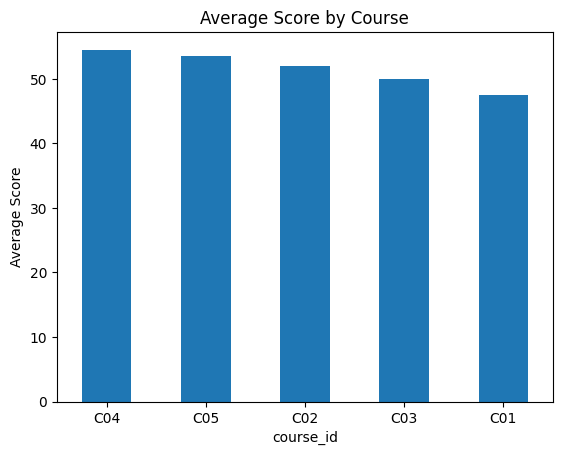

In [7]:
import matplotlib.pyplot as plt

# 1) Completion rate by college
college_comp = (df.groupby("college")["is_completed"].mean() * 100).sort_values(ascending=False)

plt.figure()
college_comp.plot(kind="bar")
plt.ylabel("Completion Rate (%)")
plt.title("Completion Rate by College")
plt.xticks(rotation=30, ha="right")
plt.show()

# 2) Avg score by college
college_score = df.groupby("college")["score"].mean().sort_values(ascending=False)

plt.figure()
college_score.plot(kind="bar")
plt.ylabel("Average Score")
plt.title("Average Score by College")
plt.xticks(rotation=30, ha="right")
plt.show()

# 3) Monthly participation trend (enrollments)
monthly_enroll = df.groupby("month")["student_id"].count().sort_index()

plt.figure()
monthly_enroll.plot(kind="line", marker="o")
plt.ylabel("Enrollments")
plt.title("Monthly Participation Trend (Enrollments)")
plt.xticks(rotation=45, ha="right")
plt.show()

# 4) Avg score by course
course_score = df.groupby("course_id")["score"].mean().sort_values(ascending=False)

plt.figure()
course_score.plot(kind="bar")
plt.ylabel("Average Score")
plt.title("Average Score by Course")
plt.xticks(rotation=0)
plt.show()
